#### Notebook config

In [13]:
# %load ~/software/fullwavepy/fullwavepy/config/jupyter.py 
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(ERROR) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
#%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [14]:
xp = PROTEUS()
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano'
exe = { 
    'fullwave':  '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'fullwave_local': '/home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'segyprep':  '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16'} 
b01 = xp.box['kol1'].box

In [6]:
!ls data

all_hy_traces_in_x8000_25000_y-3000_15000_box-OutSeis.sgy
b01_subset
bt_kol01_shape341x361.mmp
bt_x8000_18000_y4000_14000_shape201x201.mmp
dataset_obs_4104
dataset_obs_hy_box01
klaver2016_Kolumbo.csv
kol_it160_vp.txt
p14-Observed_HEAD.csv
p14-Observed.sgy
p14-StartVp_shape341x361x81.mmp
recovered_models
ueki_uwamori2016_Kolumbo.xlsx


##### Init synthetic project (see `0831...ipynb`)

In [15]:
dis01 = {
 'dt': 0.0025,
 'dx': 50,
 'ns': 3000} # NOTE

In [16]:
info = "Calculate synthetics through p14.out.vp.it[80]"
s01 = ProjSyn('method_s01', path = './', exe=exe, info=info, box=b01, **dis01, cat=0)

# Init

In [17]:
from fullwavepy.fwi.project import ProjEnsemble
class SmoothEnsemble(ProjEnsemble):
    def __init__(self, *args, **kwargs):
        self.smooth = {}
        self.proj = {}
        super().__init__(*args, **kwargs)
    def init(self, smooth_values, *args, **kwargs):
        for smooth in smooth_values:
            pname = '%s_%s' % (self.name, smooth)
            self.proj[smooth] = ProjInv(pname, *args, **kwargs)

In [18]:
path = './'
dis02 = {'ns': 2500, 'dt': 0.0025, 'dx': 50}
en = SmoothEnsemble('field_smooth', path)
en.init([1,2,3], path=path, exe=exe, box=b01, **dis02, cat=0)

# Inp

## Prep

### Get raw data

In [75]:
%%time 
for smooth, p in sorted(en.proj.items()):
    p.i.obs.raw.dupl(s01.i.ose.fname)
    p.i.rse.prep(fnames=[p.i.obs.raw.name])

Content of  .//field_smooth_1//inp/field_smooth_1-RawSeis.txt : 
field_smooth_1-Observed_raw.sgy
 
Content of  .//field_smooth_2//inp/field_smooth_2-RawSeis.txt : 
field_smooth_2-Observed_raw.sgy
 
Content of  .//field_smooth_3//inp/field_smooth_3-RawSeis.txt : 
field_smooth_3-Observed_raw.sgy
 
CPU times: user 0 ns, sys: 32 ms, total: 32 ms
Wall time: 4.15 s


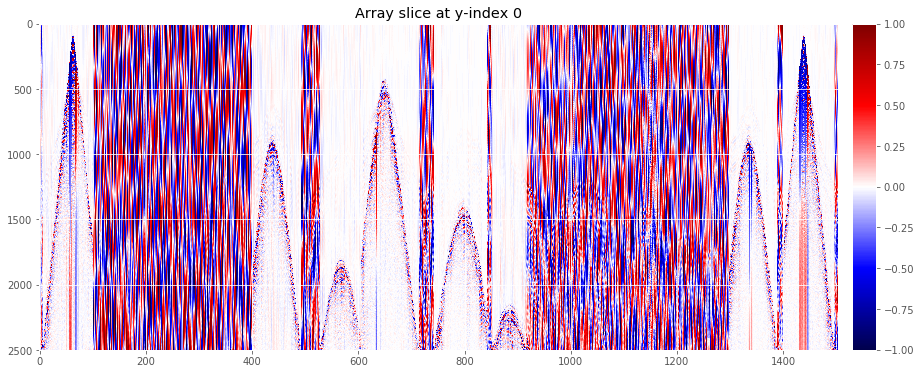

In [77]:
figure(15)
p.i.obs.raw.plot(win=dict(tracf=[4104]), norm='max')

### Source wavelet

In [36]:
for smooth, p in sorted(en.proj.items()):
    p.i.rsg.dupl('data/wavelet_19-09-22_ns2000_dt25ms.sgy')

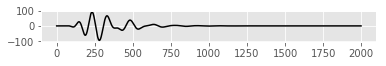

In [37]:
p.i.rsg.plot()

### Starting model

#### Vp

In [39]:
for smooth, p in sorted(en.proj.items()):
    p.i.svp.dupl('data/p14-StartVp_shape341x361x81.sgy')

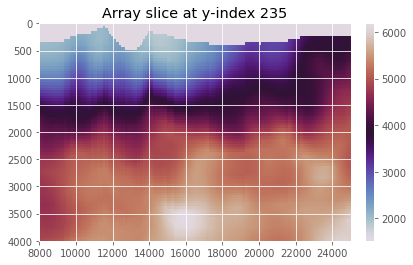

In [42]:
p.i.svp.plot(coord=235)

#### Vs

#### Epsi

#### Delta

### Preprocess input

In [76]:
%%time 
for smooth, p in sorted(en.proj.items()):
    p.i.sp.prep(reciprocity=1, ztype='d')
    p.i.sp.run()

Content of  .//field_smooth_1//inp/field_smooth_1-SegyPrep.key : 
FFID : yes
addtodepth : 0
debug : yes
dtms : 2.5
dx : 50.0
fixedarray : yes
geometry : segy
io : sgy
maxoffset : 1000000.0
minoffset : 0
nx1 : 341
nx2 : 361
nx3 : 81
outseis : yes
outsource : yes
problem : tomography
reciprocity : 1
retain : yes
text : yes
ttime : 6250.0
unique : yes
xorigin : 8000.0
xshift : 0
yorigin : -3000.0
yshift : 0
ztype : d
 

 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to field_smooth_1
 Preparing files for inversion...

 Grid points in-line:                    341
 Grid points cross-line:                 361
 Grid points vertically:                  81
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            17000.0000    
 Model width (metres):             18000.0000    
 Model depth (metres):     

### Process data

In [78]:
%%time 
kw_filt = {'pad': 100, 'f1': 2, 'f2': 3, 'f3': 4.5, 'f4': 6.5, 'zerophase': False}
kw_mute = {'twin': 1, 'syn_file': s01.o.syn}
for smooth, p in sorted(en.proj.items()):
    p.i.obs.process(kw_filt, kw_mute)

CPU times: user 5min 31s, sys: 4.2 s, total: 5min 35s
Wall time: 7min 18s


(0, 400)

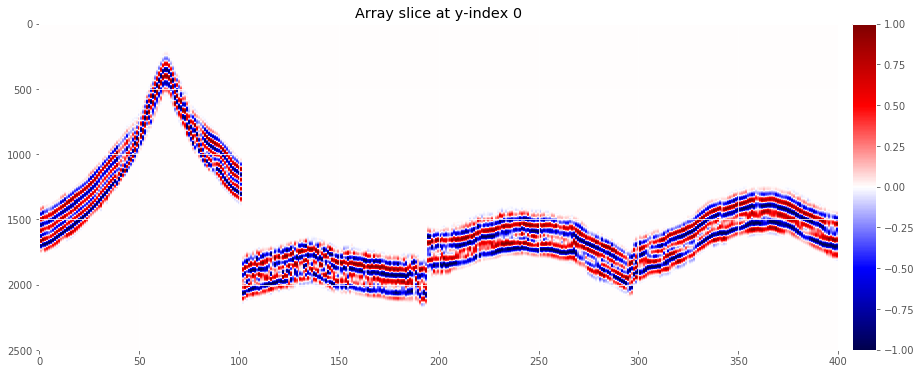

In [80]:
figure(15)
p.i.obs.plot(win=dict(tracf=[4104]), norm='max')
plt.xlim(0,400)

### Runfile

In [83]:
%%time 
for smooth, p in sorted(en.proj.items()):
    p.i.rnf.prep(sx1=smooth, sx2=smooth, sx3=smooth, # that's the whole point!!!!!
                 b_abs=40, e_abs=50)

Content of  .//field_smooth_1//inp/field_smooth_1-Runfile.key : 

    ! May 2019, K. Chrapkiewicz 
    ! THIS RUNFILE CONFORMS TO
    ! FULLWAVE REV. 688 STANDARD
    
    
    ! A. PROBLEM DEFINITION
     problem       : tomography
     domain        : time
     dim           : 3d
     equation      : acoustic
     units         : metric
     anisotropy    : none
     kernel        : low
    
     
    ! B. MODEL DEFINITION
     nx1           : 341
     nx2           : 361
     nx3           : 81
     dx            : 50.0000000
    
     
    ! C. DATA DEFINITION
     ncomp         : 16
     nshots        : 16
     nrecs         : 1505
     maxrc         : 1505
     maxps         : 1
     io            : segy
    
     
    ! D. BOUNDARY CONDITIONS
     ibfs          : 0
     multisurf     : 0
     nosprdfctrs   : 0     
     seaLevel      : 0
     maxGhostIter  : 2
     vacuum        : 0
     accuracy      : 0.001
     minGhostFS    : 0.001
     minFictFS     : 0.5
     interpMode   

## Check

In [84]:
%%time 
lll(20)
for smooth, p in sorted(en.proj.items()):
    p.i.check_by_fullwave()
lll(40)

INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: 

Fullwave is checking the input...
(exe = /home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe)
INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: Checked input & dumped canonical runfile


INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: +++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2021/11/12, 00:59:31 ===---
executable: fullwave3D.exe, version: unknown, release date: 2021-08-31
=== scheduler_getprojargs: Project name (command-line argument): "field_smooth_1"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "multisurf"
+++ ReadParms: WARNING, unknown keyword in Runfile: "nosprdfctrs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, 

INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: +++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2021/11/12, 00:59:33 ===---
executable: fullwave3D.exe, version: unknown, release date: 2021-08-31
=== scheduler_getprojargs: Project name (command-line argument): "field_smooth_2"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "multisurf"
+++ ReadParms: WARNING, unknown keyword in Runfile: "nosprdfctrs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, 

INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: +++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2021/11/12, 00:59:35 ===---
executable: fullwave3D.exe, version: unknown, release date: 2021-08-31
=== scheduler_getprojargs: Project name (command-line argument): "field_smooth_3"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "multisurf"
+++ ReadParms: WARNING, unknown keyword in Runfile: "nosprdfctrs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, 

In [32]:
# p.reinit(path_eph)
# p.i.obs.surange()

In [27]:
p.reinit('./')
p.i.ls()

Content of /media/kmc3817/DATADRIVE1/heavy_PhD/PROJECTS/Santorini-FWI/notebooks/ch08_Kolumbo_volcano/field_smooth_1/inp

total 1.6G
-rwxrwxrwx 1 root root 2.0K Nov 12 00:59 field_smooth_1-Run1.pbs
-rwxrwxrwx 1 root root    0 Nov 12 00:59 fullwave3d-verbose-slave-4
-rwxrwxrwx 1 root root    0 Nov 12 00:59 fullwave3d-verbose-slave-3
-rwxrwxrwx 1 root root    0 Nov 12 00:59 fullwave3d-verbose-slave-2
-rwxrwxrwx 1 root root    0 Nov 12 00:59 fullwave3d-verbose-slave-1
-rwxrwxrwx 1 root root    0 Nov 12 00:59 fullwave3d-verbose-scheduler
-rwxrwxrwx 1 root root 4.5K Nov 12 00:59 field_smooth_1-Canonical-Runfile.key
-rwxrwxrwx 1 root root 3.6K Nov 12 00:59 field_smooth_1-Runfile.key
-rwxrwxrwx 1 root root 236M Nov 12 00:29 field_smooth_1-Observed.sgy
-rwxrwxrwx 1 root root 236M Nov 12 00:27 field_smooth_1-Observed_filtered.sgy
-rwxrwxrwx 1 root root 254M Nov 12 00:27 field_smooth_1-Observed_taper_pad_filt.sgy
-rwxrwxrwx 1 root root 254M Nov 12 00:27 field_smooth_1-Observed_taper_pad.sgy
-rwxr

# Run

In [56]:
%%time 
for smooth, p in sorted(en.proj.items()):
#     p.reinit(path_eph) # only once, at start
    p.reinit('./')
#     p.i.pbs.no[0].prep(q='debug')
#     p.i.pbs.no[1].prep(hours=12, select=4, q='pqmrwarn') # err: obs didn't sync for proj 1&3
    p.i.pbs.no[2].prep(hours=1, select=4, q='pqmrwarn') # try again, shorter to test if OK
    p.i.rsync('my_eph')

Content of  .//field_smooth_1//inp/field_smooth_1-Run2.pbs : 
#!/bin/bash

##
# FULLWAVE3D WILL BE RUN FROM proj/out/
# For more explanation, see help(fullwavepy.project.files.runfiles.PbsFile).
#
##

#PBS -N field_smooth_1
#PBS -o ../out/field_smooth_1-JobOut2.log
#PBS -e ../out/field_smooth_1-JobErr2.log
#PBS -l walltime=01:00:00
#PBS -l select=4:mpiprocs=5:ompthreads=8:ncpus=40:mem=128gb
#PBS -l place=scatter:excl

start=`date +%s`

    # PATHS
    code_path=~/PhD/fullwave3D/rev690/bin/fullwave3D.exe
    echo 'code_path: '${code_path}

    work_dir=$PBS_O_WORKDIR/../out/ # $PBS_O_WORKDIR IS THE ONE CONTAINING THIS SCRIPT
    
    # CAVEAT  
    rm $work_dir/field_smooth_1-Runfile.key   
    rm $work_dir/field_smooth_1-Ghost.*


    # HARD-LINK INPUT FILES TO OUTPUT DIR WHERE THE CODE WILL RUN
    ln $PBS_O_WORKDIR/* $work_dir
    
    # CHANGE DIRECTORY TO PROJECT OUTPUT
    cd $work_dir
    
    
# DISABLE PINNING OF THE PROCESSES (MAKE ALL NODE CORES AVAILABLE TO ALL PROCESSES)
un

## Logs

In [48]:
%%time 
# no = 1
# for smooth, p in sorted(en.proj.items()):
#     p.reinit(path_eph)
#     p.o.e.no[no].cat()
#     break

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


# Out

## List output files

In [39]:
%%time 
for smooth, p in sorted(en.proj.items()):
    p.reinit(path_eph)
    p.o.ls()

Content of /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/field_smooth_1/out

total 1.4G
-rwx------ 1 kmc3817 root  379 Nov 12 08:36 field_smooth_1-JobOut1.log
-rwx------ 1 kmc3817 root 6.4K Nov 12 08:36 field_smooth_1-JobErr1.log
-rwx------ 1 kmc3817 root 3.8K Nov 12 08:36 field_smooth_1-Out1.log
-rwx------ 1 kmc3817 root 2.3K Nov 12 08:36 field_smooth_1-Err1.log
-rwx------ 1 kmc3817 root 2.4K Nov 12 01:02 field_smooth_1-JobInfo1.log
-rwx------ 1 kmc3817 root 4.5K Nov 12 01:02 field_smooth_1-Canonical-Runfile.key
-rwx------ 1 kmc3817 root 2.0K Nov 12 00:59 field_smooth_1-Run1.pbs
-rwx------ 1 kmc3817 root    0 Nov 12 00:59 fullwave3d-verbose-slave-4
-rwx------ 1 kmc3817 root    0 Nov 12 00:59 fullwave3d-verbose-slave-3
-rwx------ 1 kmc3817 root    0 Nov 12 00:59 fullwave3d-verbose-slave-2
-rwx------ 1 kmc3817 root    0 Nov 12 00:59 fullwave3d-verbose-slave-1
-rwx------ 1 kmc3817 root    0 Nov 12 00:59 fullwave3d-verbose-scheduler
-rwx------ 1 kmc3817 root 3.6K Nov 1

Content of /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/field_smooth_3/out

total 0
 
CPU times: user 472 ms, sys: 96 ms, total: 568 ms
Wall time: 1.66 s


## Objective function

CPU times: user 220 ms, sys: 36 ms, total: 256 ms
Wall time: 1.14 s


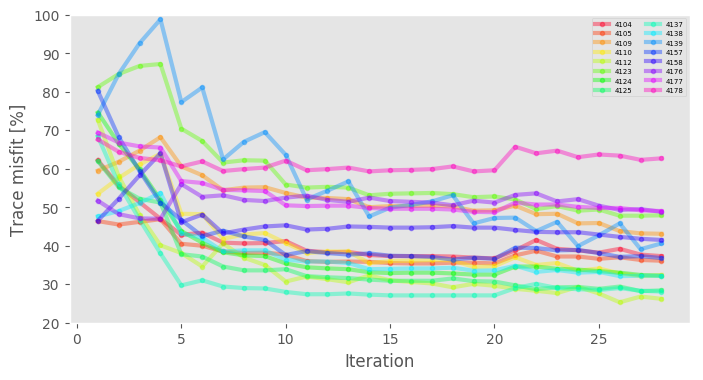

In [46]:
%%time 
for smooth, p in sorted(en.proj.items()):
    if smooth != 2:
        continue
    p.reinit(path_eph)
    figure(8,4)
    p.o.fit.plot(run_ids=[1], legend_size=5)
    plt.ylim(20,100)

## Data fit

### Phase plots

### Waveform plots

## Models

In [55]:
p.o.vp.it[25]

CPU times: user 252 ms, sys: 32 ms, total: 284 ms
Wall time: 772 ms


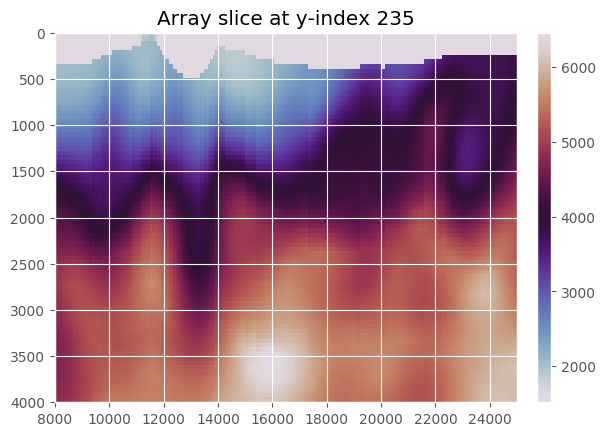

In [54]:
%%time 
for smooth, p in sorted(en.proj.items()):
    if smooth != 2:
        continue
    p.reinit(path_eph)
    p.o.vp.it[25].plot(coord=235,  overwrite_mmp=0)

# ...